In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [6]:
from duckduckgo_search import *
from fastbook import *
from fastcore.all import *

#Esta versión no funciona por problemas del API de duckduckgo
#def search_images(term, max_images=30):
#    print(f"Searching for '{term}'")
#    return L(ddg_images(term, max_results=max_images)).itemgot('image')

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
  return search_images_ddg(term, max_images=max_images)

Searching for 'bird photos'
['https://wallpaperaccess.com/full/775987.jpg']


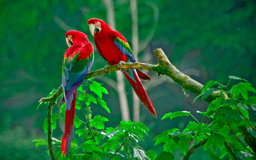

In [7]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
print(urls) #Imprimir la URL de la imagen
urls[0]

from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256) #Dibujar la imagen descargada

Searching for 'forest photos'


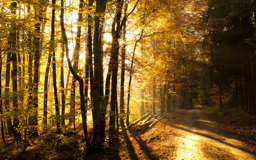

In [8]:
#Descargar una imagen de un bosque, esperar que no tenga pájaros 
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256) 

In [9]:
#Crear carpetas para pruebas donde se descargaran imágenes
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

#Descargar imagenes de pájaros y bosques
#Se descargaran 3 búsquedas, durará unos de minutos, tener paciencia
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [13]:
#Comprobar que las imagenes se decagraron bien, ie: no son archivos corruptos
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print("Imágenes corruptas: " + str(len(failed)))


Imágenes corruptas: 0


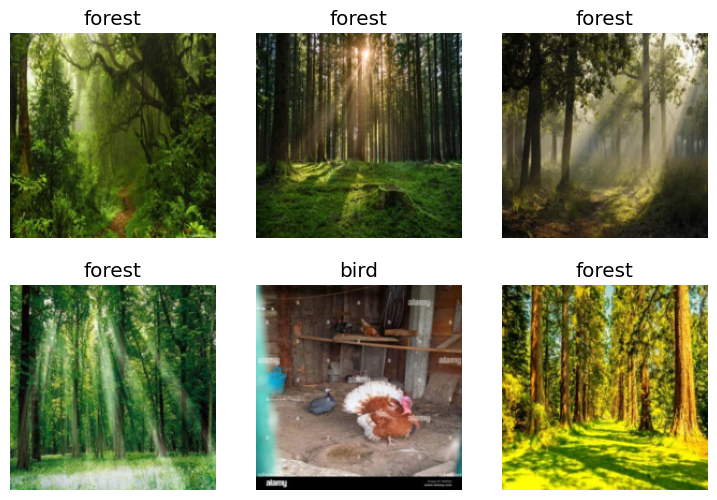

In [14]:
#Crear el DataLoader y DataBlock
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),              #Entradas = Imagenes, en categprías
    get_items=get_image_files,                       #Retornar las imágenes en un path. "get_image_files" es una función
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #Dividir las imagenes en entrenamiento/validación, 80/20% con semilla aleatoria de 42
    get_y=parent_label,                              #Obtiene el nombre de la categoría según el folder padre (bird o forest)
    item_tfms=[Resize(192, method='squish')]#,       #Convertir las imágenes a 192x192px
    #batch_tfms=aug_transforms(mult=2)               #HAce transformaciones a las imágenes para crear mas datos
    #item_tmfs = [RandomResizedCrop(128, min_scale=0.3)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)#Mostrar una parte de la entrada

In [18]:
#Crear el modelo, "learn" lo contiene
#resnet18 es el método
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3) #Un método de fastai predeterminado para mejorar el modelo

epoch,train_loss,valid_loss,error_rate,time
0,0.728186,0.407355,0.151515,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.197020,0.168520,0.090909,00:21
1,0.114231,0.074628,0.060606,00:21
2,0.104127,0.036396,0.000000,00:21


In [21]:
#Insertar la imagen inicial par probar el modelo
is_bird,_,probs = learn.predict(PILImage.create('Herman_Goldstine.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9267


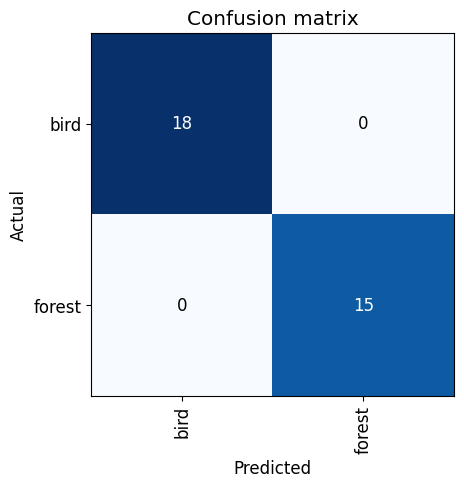

In [22]:
#Crear matriz de confusión
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

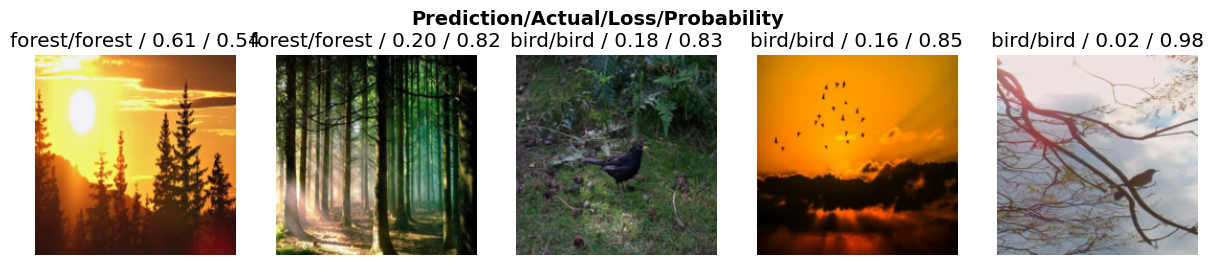

In [26]:
#Peores imágenes
interp.plot_top_losses(5, nrows=1)

#Visualización Limpia
from fastai.vision.widgets import *
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [44]:
#Cargar un modelo
learn = load_learner(path/'export.pkl')
#learn_inf.predict('images/grizzly.jpg') #Usar el modelo

In [34]:
#Crear un pywidget
#Permiten unir Python con javascript

#hide_output
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [35]:
#hide
# Fingir que se presionó el botón, límite por el notebook
btn_upload = SimpleNamespace(data = ['bird.jpg'])
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl
pred, pred_idx,probs = learn.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: bird; Probability: 1.0000')

In [38]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [42]:
btn_upload = widgets.FileUpload()
#hide_output
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [45]:
#!pip install voila

In [47]:
#!jupyter serverextension enable --sys-prefix voila
!jupyter server extension enable --py jupyter_http_over_ws

Extension package jupyter_lsp took 0.1821s to import
Extension package jupyterlab took 0.5601s to import
Extension package voila.server_extension took 0.3037s to import
Enabling: jupyter_http_over_ws
- Writing config: C:\Python312\etc\jupyter
    - Validating jupyter_http_over_ws...
      jupyter_http_over_ws  ok
    - Extension successfully enabled.
